<a href="https://colab.research.google.com/github/21amY26/RealTimeFaceRecognition/blob/master/autism_eye_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.7 MB/s eta 0:00:00


In [ ]:
pip install tensorflow

In [ ]:
!pip install split_folders

In [ ]:
pip install mlxtend

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import splitfolders
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense,Input, Conv2D, MaxPooling2D, Activation, Dropout, BatchNormalization, Flatten, GlobalAveragePooling2D , Multiply
from tensorflow.keras.models import Model, load_model, Sequential
from keras_tuner.tuners import Hyperband
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
import itertools
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121 , ResNet50,InceptionV3,Xception,EfficientNetB7
from google.colab import drive

import warnings
warnings.filterwarnings("ignore")


In [ ]:
drive.mount('/content/drive')
loc = "/content/drive/MyDrive/ASDeyedata"

Mounted at /content/drive


In [ ]:
# output directories
os.makedirs('output', exist_ok = True)
os.makedirs('output/train', exist_ok = True)
os.makedirs('output/val', exist_ok = True)
os.makedirs('output/test', exist_ok = True)

In [ ]:
splitfolders.ratio(loc, output = 'output', seed = 0, ratio = (0.8,0.1,0.1))

Copying files: 547 files [00:16, 32.71 files/s] 


In [ ]:
train_dir = "output/train"
test_dir = "output/test"
val_dir = "output/val"

In [ ]:
# training data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size = (224,224),
    batch_size = 32,
    label_mode = 'categorical',
    shuffle = True,
    seed = 0)


# testing data
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size = (224,224),
    batch_size = 32,
    label_mode = 'categorical',
    shuffle = False)


# validation data
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size = (224,224),
    batch_size = 32,
    label_mode = 'categorical',
    shuffle = False)

Found 437 files belonging to 2 classes.
Found 57 files belonging to 2 classes.
Found 53 files belonging to 2 classes.


In [ ]:
from sklearn.utils import class_weight
import numpy as np
import tensorflow as tf

# === AUGMENTATION ===
# Define augmentation pipeline
augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
])

# Apply augmentation only to training data
train_data = train_data.map(lambda x, y: (augmentation(x, training=True), y),
                            num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch data for performance
train_data = train_data.prefetch(tf.data.AUTOTUNE)
val_data = val_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

# === CLASS WEIGHT CALCULATION ===
# Extract true labels for computing class weights
y_train_labels = []
for _, labels in train_data:
    y_train_labels.extend(np.argmax(labels.numpy(), axis=1))

# Compute balanced class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


Class Weights: {0: np.float64(0.833969465648855), 1: np.float64(1.2485714285714287)}


In [ ]:
class_names = train_data.class_names
class_count = len(class_names)
print("Number of classes : ",class_count)
print(class_names)

Number of classes :  2
['TCImages-0', 'TSImages-1']


In [ ]:
# Count samples in each class for training and testing data
train_class_counts = {class_name: 0 for class_name in class_names}
test_class_counts = {class_name: 0 for class_name in class_names}

# Count training samples
for images, labels in train_data:
    for label in labels.numpy():
        class_index = np.argmax(label)  # Convert one-hot to class index
        train_class_counts[class_names[class_index]] += 1

# Count test samples
for images, labels in test_data:
    for label in labels.numpy():
        class_index = np.argmax(label)  # Convert one-hot to class index
        test_class_counts[class_names[class_index]] += 1

# Print class-wise distribution
print("\n### Class Distribution ###")
print("Class | Training Samples | Test Samples | Total Samples")
print("-" * 50)
for class_name in class_names:
    total_samples = train_class_counts[class_name] + test_class_counts[class_name]
    print(f"{class_name:<10} | {train_class_counts[class_name]:<16} | {test_class_counts[class_name]:<11} | {total_samples:<13}")



### Class Distribution ###
Class | Training Samples | Test Samples | Total Samples
--------------------------------------------------
TCImages-0 | 262              | 34          | 296          
TSImages-1 | 175              | 23          | 198          


In [ ]:
# Initialize counts
train_class_counts = {class_name: 0 for class_name in class_names}
test_class_counts = {class_name: 0 for class_name in class_names}
val_class_counts = {class_name: 0 for class_name in class_names}

# Count training samples
for images, labels in train_data:
    for label in labels.numpy():
        class_index = np.argmax(label)  # Convert one-hot to class index
        train_class_counts[class_names[class_index]] += 1

# Count validation samples
for images, labels in val_data:
    for label in labels.numpy():
        class_index = np.argmax(label)  # Convert one-hot to class index
        val_class_counts[class_names[class_index]] += 1

# Count test samples
for images, labels in test_data:
    for label in labels.numpy():
        class_index = np.argmax(label)  # Convert one-hot to class index
        test_class_counts[class_names[class_index]] += 1

# Print class-wise distribution
print("\n### Class Distribution ###")
print("Class       | Training Samples | Validation Samples | Test Samples | Total Samples")
print("-" * 75)
for class_name in class_names:
    total_samples = (
        train_class_counts[class_name] +
        val_class_counts[class_name] +
        test_class_counts[class_name]
    )
    print(f"{class_name:<12} | {train_class_counts[class_name]:<17} | "
          f"{val_class_counts[class_name]:<19} | {test_class_counts[class_name]:<12} | {total_samples:<13}")



### Class Distribution ###
Class       | Training Samples | Validation Samples | Test Samples | Total Samples
---------------------------------------------------------------------------
TCImages-0   | 262               | 32                  | 34           | 328          
TSImages-1   | 175               | 21                  | 23           | 219          


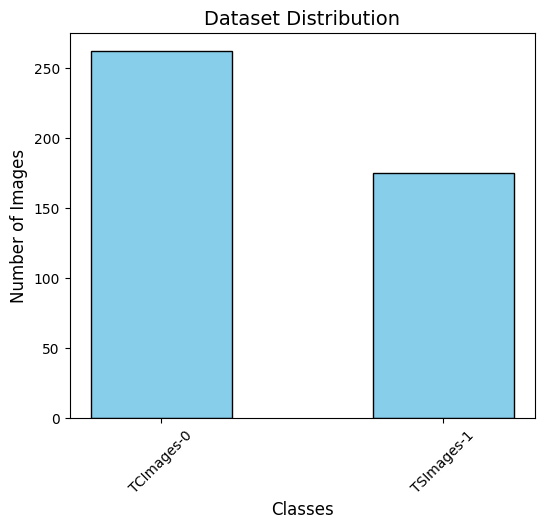

In [ ]:
# Count number of images per class
class_counts = {class_name: 0 for class_name in class_names}

for images, labels in train_data:
    label_indices = np.argmax(labels.numpy(), axis=1)
    for idx in label_indices:
        class_counts[class_names[idx]] += 1

# Reduce gaps by adjusting figure size and bar width
plt.figure(figsize=(6, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue', edgecolor='black', width=0.5)  # Increase width

# Labels and title
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Dataset Distribution", fontsize=14)
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
def create_model(model_name):

    input_shape = (224,224,3)
    base_model = None
    if model_name == "ResNet50":
        base_model = ResNet50(include_top=False,
                                  weights="imagenet",
                                  input_shape=input_shape,
                                  pooling='max')
    elif model_name == "Xception":
        base_model = Xception(include_top = False,
                              weights = "imagenet",
                              input_shape = input_shape,
                              pooling = "max")
    elif model_name == "EfficientNetB7":
        base_model = EfficientNetB7(include_top = False,
                                    weights = "imagenet",
                                    input_shape = input_shape,
                                    pooling = "max")
    elif model_name == "InceptionV3":
        base_model = InceptionV3(include_top=False,
                                  weights="imagenet",
                                  input_shape=input_shape,
                                  pooling='max')


    x = base_model.output
    #x = GlobalAveragePooling2D()(x)
    x = BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.002)(x)
    x = Dense(128, activation = 'relu')(x)
    x = Dropout(rate = 0.2, seed = 0)(x)
    output = Dense(class_count, activation = 'softmax')(x)

    model = Model(inputs = base_model.input, outputs = output)

    model.compile(tf.keras.optimizers.Adam(learning_rate = 0.0001),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

In [ ]:
def train_and_evaluate_model(model, train_data, val_data, test_data, model_name):
    # Train the model
    #history = model.fit(train_data, epochs=60, validation_data=val_data)
    history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=60,
    class_weight=class_weights_dict)

    # Extract training accuracy from history
    training_accuracy = history.history['accuracy'][-1]
    validation_accuracy = history.history['val_accuracy'][-1]

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(test_data)

    print(f"\n--- Model Evaluation: {model_name} ---")
    print(f"Training Accuracy: {training_accuracy:.4f}")
    print(f"Validation Accuracy: {validation_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Prepare test data for prediction
    test_data_array, labels_array = [], []
    for images, labels in test_data:
        test_data_array.append(images.numpy())
        labels_array.append(labels.numpy())

    X_test = np.concatenate(test_data_array, axis=0)
    y_test = np.concatenate(labels_array, axis=0)

    # Get model predictions
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, cmap='crest', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Plot Accuracy and Loss
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy Plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    axes[0].set_title(f'Accuracy vs Epochs for {model_name}')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Loss Plot
    axes[1].plot(history.history['loss'], label='Training Loss', marker='o', color='r')
    axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s', color='g')
    axes[1].set_title(f'Loss vs Epochs for {model_name}')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
'''import tensorflow as tf
import keras_tuner as kt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

input_shape = (224, 224, 3)
class_names = train_data.class_names
class_count = len(class_names)

def build_model(hp, model_name):
    if model_name == "ResNet50":
        base_model = ResNet50(include_top=False, weights="imagenet", input_shape=input_shape, pooling='max')
    elif model_name == "InceptionV3":
        base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=input_shape, pooling='max')

    x = base_model.output
    x = BatchNormalization()(x)
    x = Dense(hp.Int('units', min_value=64, max_value=256, step=64), activation='relu')(x)
    x = Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1))(x)
    output = Dense(class_count, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model
      def tune_and_evaluate(model_name):
    print(f"\n### Running Hyperband for {model_name} ###")

    tuner = kt.Hyperband(lambda hp: build_model(hp, model_name),
                         objective='val_accuracy',
                         max_epochs=20,
                         factor=3,
                         directory='hyperband_tuning',
                         project_name=f'{model_name}_Tuning')

    tuner.search(train_data, epochs=10, validation_data=val_data)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hps)

    history = best_model.fit(train_data, epochs=60, validation_data=val_data)

    test_loss, test_accuracy = best_model.evaluate(test_data)
    print(f"\n### Test Accuracy for {model_name}: {test_accuracy:.4f} ###")

    test_data_array, labels_array = [], []
    for images, labels in test_data:
        test_data_array.append(images.numpy())
        labels_array.append(labels.numpy())

    X_test = np.concatenate(test_data_array, axis=0)
    y_test = np.concatenate(labels_array, axis=0)

    y_pred = best_model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=class_count)

    print(f"\n### Classification Report for {model_name} ###")
    print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

    y_test_labels = np.argmax(y_test, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)

    f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
    precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
    accuracy = accuracy_score(y_test_labels, y_pred_labels)

    print(f"\n### Metrics for {model_name} ###")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(y_test_labels, y_pred_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, cmap='crest', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy vs Epochs for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

tune_and_evaluate("ResNet50")
tune_and_evaluate("InceptionV3")'''


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 37)

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 415s 12s/step - accuracy: 0.6638 - loss: 0.7773 - val_accuracy: 0.6226 - val_loss: 0.7693
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 936ms/step - accuracy: 0.8297 - loss: 0.3845 - val_accuracy: 0.6226 - val_loss: 0.8191
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 924ms/step - accuracy: 0.8960 - loss: 0.2838 - val_accuracy: 0.6226 - val_loss: 0.7910
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 910ms/step - accuracy: 0.9432 - loss: 0.1497 - val_accuracy: 0.7170 - val_loss: 0.7876
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 896ms/step - accuracy: 0.9461 - loss: 0.1383 - val_accuracy: 0.6226 - val_loss: 0.8883
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 913ms/step - accuracy: 0.9812 - loss: 0.0746 - val_accuracy: 0.5472 - val_loss: 0.9484
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 909ms/step - accuracy: 0.9904 - loss: 0.0556 - val_accuracy: 0.4717 - val_loss: 1.0595
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 91

1/2 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 16s/step

Classification Report:
              precision    recall  f1-score   support

  TCImages-0       0.89      0.47      0.62        34
  TSImages-1       0.54      0.91      0.68        23

    accuracy                           0.65        57
   macro avg       0.71      0.69      0.65        57
weighted avg       0.75      0.65      0.64        57



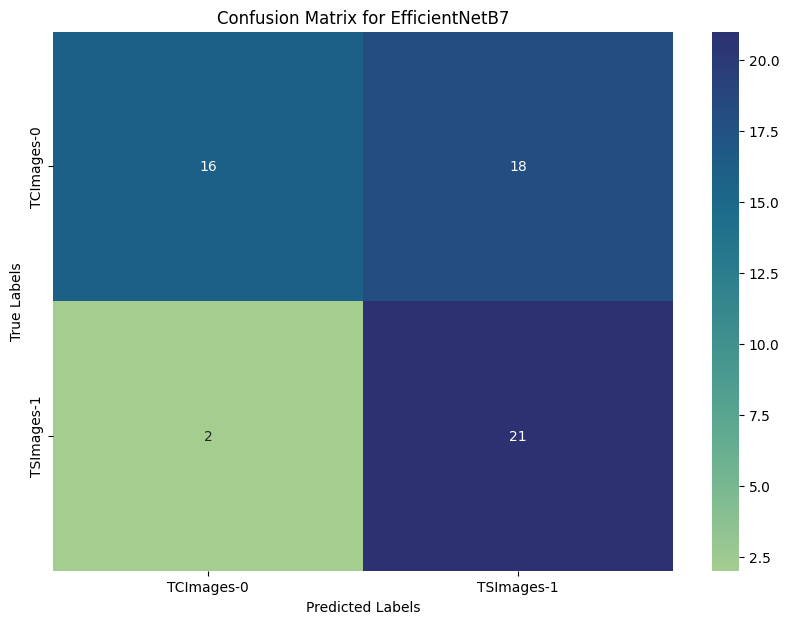

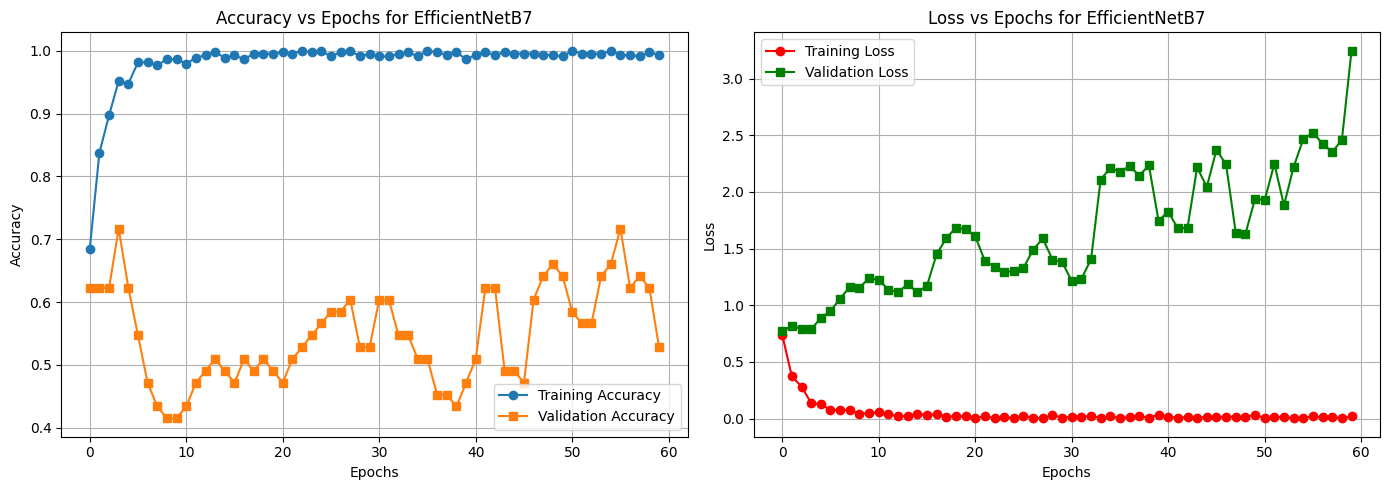

In [ ]:
model_name = "EfficientNetB7"
model = create_model(model_name)
train_and_evaluate_model(model, train_data, val_data, test_data, model_name)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.5177 - loss: 1.1982 - val_accuracy: 0.3962 - val_loss: 3.0252
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 466ms/step - accuracy: 0.8552 - loss: 0.4127 - val_accuracy: 0.3962 - val_loss: 4.6355
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 480ms/step - accuracy: 0.9238 - loss: 0.1861 - val_accuracy: 0.3962 - val_loss: 2.7312
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 525ms/step - accuracy: 0.9745 - loss: 0.0972 - val_accuracy: 0.3962 - val_loss: 2.6238
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 516ms/step - accuracy: 0.9863 - loss: 0.0509 - val_accuracy: 0.3962 - val_loss: 2.5610
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 469ms/step - accuracy: 0.9753 - loss: 0.0561 - val_accuracy: 0.3962 - val_loss: 2.5049
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 464ms/step - accuracy: 0.9849 - loss: 0.0489 - val_accuracy: 0.3962 - val_loss: 1.8444
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 466ms/ste

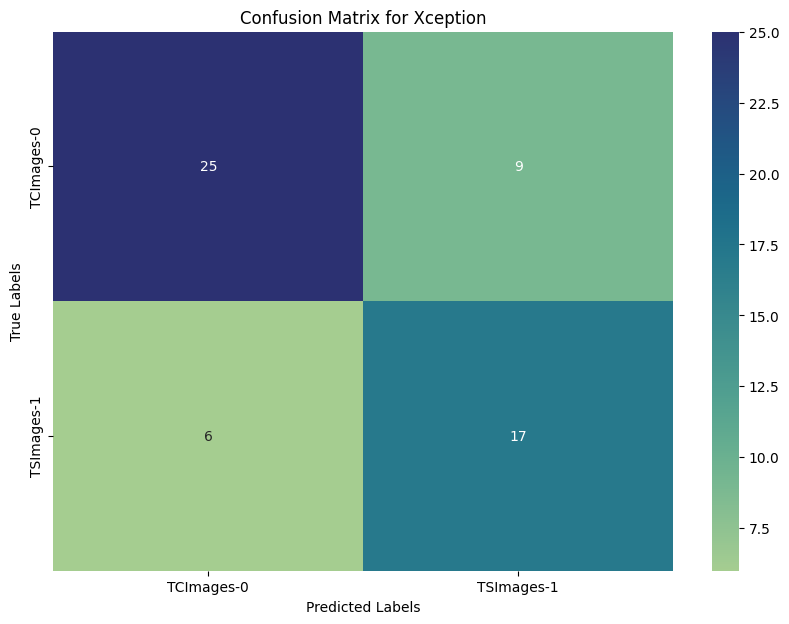

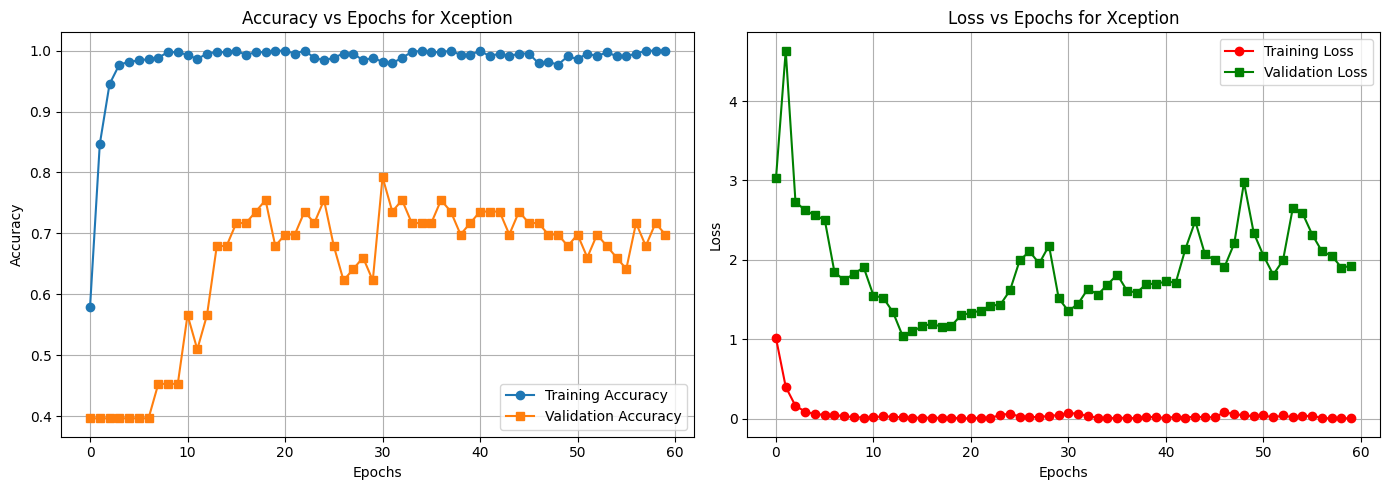

In [ ]:
model_name = "Xception"
model = create_model(model_name)
train_and_evaluate_model(model, train_data, val_data, test_data, model_name)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.6258 - loss: 0.9029 - val_accuracy: 0.5472 - val_loss: 1.3817
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step - accuracy: 0.8902 - loss: 0.2739 - val_accuracy: 0.5849 - val_loss: 1.0183
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 310ms/step - accuracy: 0.9746 - loss: 0.0987 - val_accuracy: 0.5849 - val_loss: 0.8830
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.9936 - loss: 0.0425 - val_accuracy: 0.5660 - val_loss: 0.7565
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - accuracy: 1.0000 - loss: 0.0213 - val_accuracy: 0.6415 - val_loss: 0.6952
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 318ms/step - accuracy: 0.9955 - loss: 0.0191 - val_accuracy: 0.6604 - val_loss: 0.6794
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 314ms/step - accuracy: 1.0000 - loss: 0.0138 - val_accuracy: 0.6792 - val_loss: 0.6948
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step - 

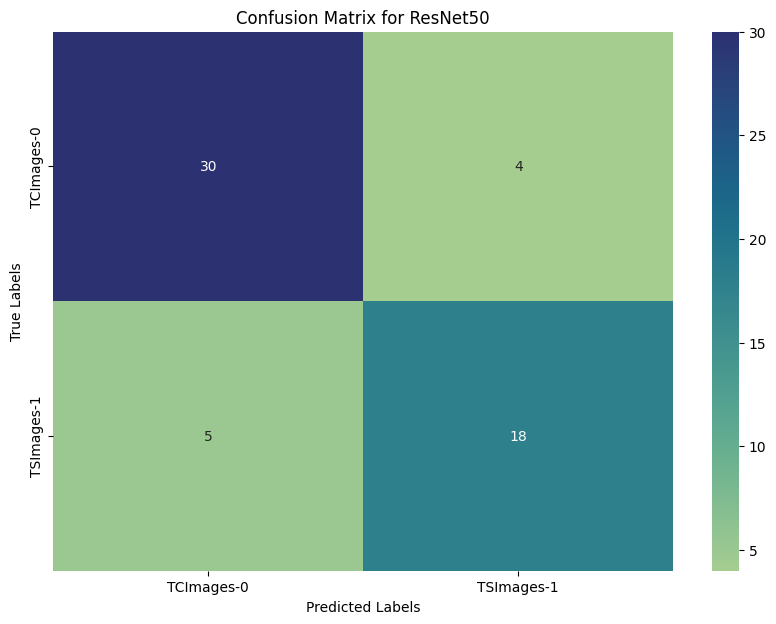

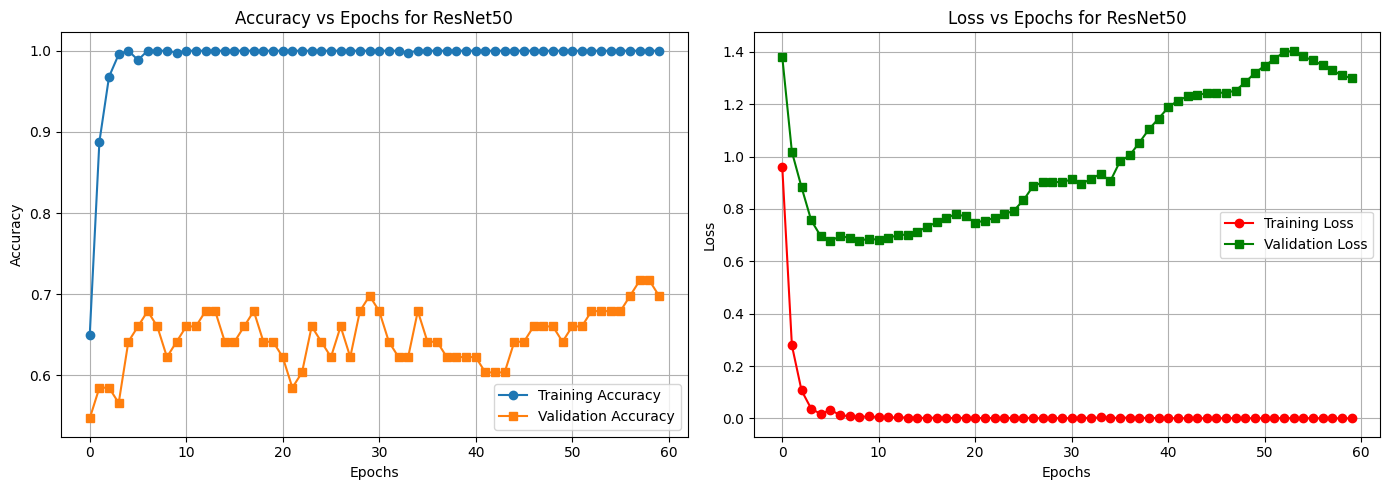

In [ ]:
model_name = "ResNet50"
model = create_model(model_name)
train_and_evaluate_model(model, train_data, val_data, test_data, model_name)
model.save("autism_eye_model.h5")

In [ ]:
from google.colab import files
files.download("autism_eye_model.h5")


In [ ]:
model_name = "InceptionV3"
model = create_model(model_name)
train_and_evaluate_model(model, train_data, val_data, test_data, model_name)
model.save("inception_eye_model.h5")

NameError: name 'create' is not defined

In [ ]:
def create_modified_cnn(input_shape=(224, 224, 3), class_count=2):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(class_count, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_and_evaluate_model(model, train_data, val_data, test_data, model_name, class_names):#Used for CNN for trial(Not for other models)
    # Train the model
    history = model.fit(train_data, epochs=60, validation_data=val_data)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(test_data)
    print(f"\n===== Model Evaluation: {model_name} =====")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Extract training accuracy and validation accuracy
    final_train_accuracy = history.history['accuracy'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]

    print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
    print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

    # Prepare test data
    test_data_array = []
    labels_array = []
    for images, labels in test_data:
        test_data_array.append(images.numpy())
        labels_array.append(labels.numpy())

    X_test = np.concatenate(test_data_array, axis=0)
    y_test = np.concatenate(labels_array, axis=0)

    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Print classification report
    print("\n===== Classification Report =====")
    print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

    # Compute additional metrics
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    accuracy = accuracy_score(y_test_classes, y_pred_classes)

    print("\n===== Model Performance Metrics =====")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Overall Accuracy: {accuracy:.4f}")

    # compare with true labels
    cfm = confusion_matrix(y_pred1, y_true1, normalize='true')

    # plot size
    fig, ax = plt.subplots(figsize=(18,20))
    # print confusion matrix
    s = sb.heatmap(cfm,
                    annot=True,
                  cmap=plt.cm.Blues,
                    center=0.8,
                    fmt='.1%',
                    linewidths=.5,
                    cbar_kws={'format': FuncFormatter(lambda x, pos: '{:.0%}'.format(x))}, #'label': 'Percentage'
                    linecolor='white',
                    ax=ax)
    # set labels
    s.set(xlabel='Predict', ylabel='True')
    s.set(title='Confusion Matrix')
    s.set(xticklabels=class_labels, yticklabels=class_labels)

    # Plot accuracy and loss
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy Plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    axes[0].set_title(f'Accuracy vs Epochs for {model_name}')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Loss Plot
    axes[1].plot(history.history['loss'], label='Training Loss', marker='o', color='r')
    axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s', color='g')
    axes[1].set_title(f'Loss vs Epochs for {model_name}')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
model_name = "Modified CNN"
input_shape = (224, 224, 3)
class_count = 2
model = create_modified_cnn(input_shape=input_shape, class_count=class_count)
train_and_evaluate_model(model, train_data, val_data, test_data, model_name, class_names)

model.save("modified_cnn_model.h5")

In [ ]:
def extract_features(model_name, dataset):
    base_model = None
    input_shape = (224, 224, 3)

    if model_name == "ResNet50":
        base_model = ResNet50(include_top=False, weights="imagenet", input_shape=input_shape, pooling='avg')
    elif model_name == "InceptionV3":
        base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=input_shape, pooling='avg')
    elif model_name == "EfficientNetB7":
        base_model = EfficientNetB7(include_top=False, weights="imagenet", input_shape=input_shape, pooling='avg')

    feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

    features_list = []
    labels_list = []

    for images, labels in dataset:
        features = feature_extractor.predict(images)
        features_list.append(features)
        labels_list.append(labels.numpy())

    X_features = np.concatenate(features_list, axis=0)
    y_labels = np.concatenate(labels_list, axis=0)
    y_labels = np.argmax(y_labels, axis=1)  # Convert one-hot to labels

    return X_features, y_labels


In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def classify_with_svm(X_train, y_train, X_test, y_test):
    clf = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10, gamma='scale', probability=True))
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print("\nSVM Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    acc = accuracy_score(y_test, y_pred)
    print(f"SVM Test Accuracy: {acc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, cmap='crest', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix for CNN + SVM')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

SVM Classification Report:
              precision    recall  f1-score   support

  TCImages-0       0.91      0.94      0.93        34
  TSImages-1       0.91      0.87      0.89        23

    accuracy                           0.91        57
   macro avg       0.91      0.91      0.91        57
weighted avg       0.91      0.91      0.91        57

SVM Test Accuracy:

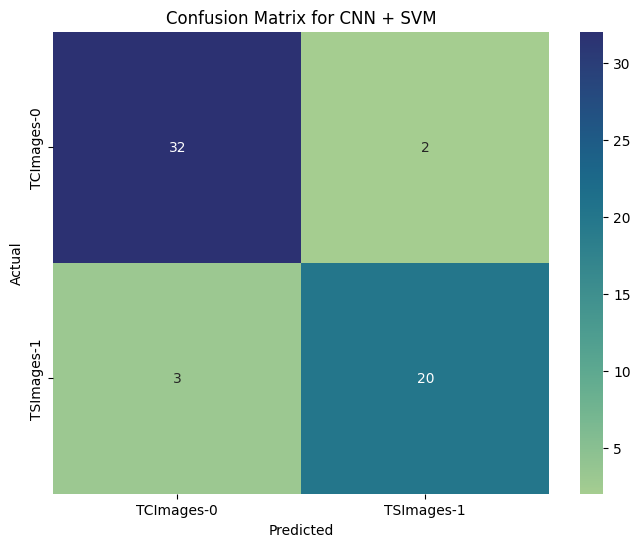

In [ ]:
# Extract features from training and test sets
X_train_feat, y_train_feat = extract_features("ResNet50", train_data)
X_test_feat, y_test_feat = extract_features("ResNet50", test_data)

# Train and evaluate SVM
classify_with_svm(X_train_feat, y_train_feat, X_test_feat, y_test_feat)


In [ ]:
!pip install split_folders scikit-image opencv-python-headless scikit-learn


In [ ]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply Local Binary Pattern
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')

    # Normalize and scale to uint8
    lbp_scaled = np.uint8(255 * (lbp - lbp.min()) / (lbp.max() - lbp.min()))

    # Apply GLCM
    glcm = graycomatrix(lbp_scaled, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]

    return lbp_scaled


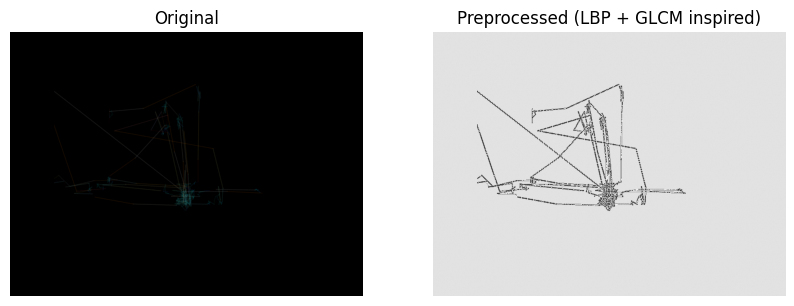

In [ ]:
from PIL import Image
import os

# Sample image from one class
sample_path = '/content/drive/MyDrive/ASDeyedata/TSImages-1'
image_name = os.listdir(sample_path)[0]
img = Image.open(os.path.join(sample_path, image_name)).convert("RGB")
img_np = np.array(img)

processed = preprocess_image(img_np)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(processed, cmap='gray')
plt.title("Preprocessed (LBP + GLCM inspired)")
plt.axis('off')
plt.show()


In [ ]:
!pip install keras-tuner --upgrade
!pip install split_folders

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import splitfolders
from google.colab import drive
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Lambda, LSTM, TimeDistributed
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import random

drive.mount('/content/drive')

# Prepare data directories
loc = "/content/drive/MyDrive/ASDeyedata"
splitfolders.ratio(loc, output='output', seed=0, ratio=(0.8, 0.1, 0.1))
train_dir = "output/train"
val_dir = "output/val"
test_dir = "output/test"

# Load datasets
train_data = image_dataset_from_directory(train_dir, image_size=(224, 224), batch_size=32, label_mode='categorical', shuffle=True)
val_data = image_dataset_from_directory(val_dir, image_size=(224, 224), batch_size=32, label_mode='categorical')
test_data = image_dataset_from_directory(test_dir, image_size=(224, 224), batch_size=32, label_mode='categorical')
class_names = train_data.class_names
class_count = len(class_names)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Copying files: 547 files [00:02, 231.74 files/s]

Found 437 files belonging to 2 classes.
Found 53 files belonging to 2 classes.
Found 57 files belonging to 2 classes.


In [ ]:
def create_model(input_shape=(224, 224, 3), class_count=2, learning_rate=1e-4, dropout_rate=0.3, use_lstm=True):
    resnet = Xception(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')
    resnet.trainable = False

    inputs = Input(shape=input_shape)
    x = resnet(inputs, training=False)

    if use_lstm:
        x = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)
        x = LSTM(64, return_sequences=False)(x)

    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    xception = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape, pooling='avg')
    xception.trainable = False
    x2 = xception(inputs, training=False)

    x = tf.keras.layers.Concatenate()([x, x2])
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(class_count, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
def chaos_butterfly_optimization(train_data, val_data, iterations=5):
    best_accuracy = 0
    best_params = {}

    for i in range(iterations):
        learning_rate = 10 ** np.random.uniform(-5, -3)
        dropout_rate = np.random.uniform(0.2, 0.5)
        use_lstm = random.choice([True, False])

        print(f"\nIteration {i+1}: LR={learning_rate:.6f}, Dropout={dropout_rate:.2f}, LSTM={use_lstm}")
        model = create_model(learning_rate=learning_rate, dropout_rate=dropout_rate, use_lstm=use_lstm)
        history = model.fit(train_data, validation_data=val_data, epochs=5, verbose=0)

        val_acc = history.history['val_accuracy'][-1]
        print(f"Validation Accuracy: {val_acc:.4f}")

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_params = {
                'learning_rate': learning_rate,
                'dropout_rate': dropout_rate,
                'use_lstm': use_lstm
            }

    print("\nBest Hyperparameters:", best_params)
    return best_params



Iteration 1: LR=0.000049, Dropout=0.20, LSTM=True
Validation Accuracy: 0.6226

Iteration 2: LR=0.000578, Dropout=0.39, LSTM=True
Validation Accuracy: 0.7170

Iteration 3: LR=0.000056, Dropout=0.26, LSTM=True
Validation Accuracy: 0.6792

Iteration 4: LR=0.000100, Dropout=0.32, LSTM=False
Validation Accuracy: 0.6604

Iteration 5: LR=0.000083, Dropout=0.38, LSTM=False
Validation Accuracy: 0.6226

Best Hyperparameters: {'learning_rate': 0.0005779341782349939, 'dropout_rate': 0.39499066479619394, 'use_lstm': True}
Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 590ms/step - accuracy: 0.6851 - loss: 0.7942 - val_accuracy: 0.7170 - val_loss: 0.5940
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step - accuracy: 0.7036 - loss: 0.6232 - val_accuracy: 0.7358 - val_loss: 0.5888
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step - accuracy: 0.7671 - loss: 0.4968 - val_accuracy: 0.6226 - val_loss: 0.5758
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - accuracy: 0.7891 - loss: 0.4700 - val_accurac

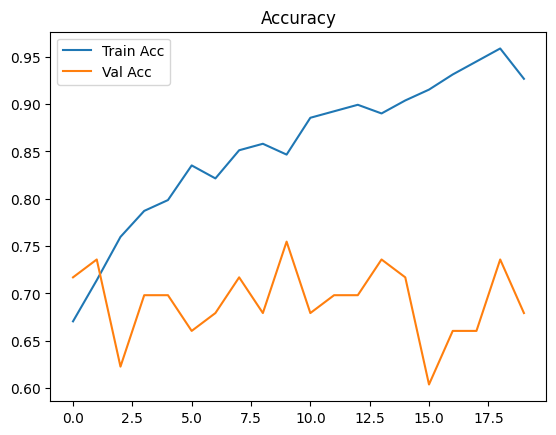

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:
              precision    recall  f1-score   support

  TCImages-0       0.89      0.91      0.90        34
  TSImages-1       0.86      0.83      0.84        23

    accuracy                           0.88        57
   macro avg       0.87      0.87      0.87        57
weighted avg       0.88      0.88      0.88        57



In [ ]:
best_params = chaos_butterfly_optimization(train_data, val_data)

final_model = create_model(
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
    use_lstm=best_params['use_lstm']
)

history = final_model.fit(train_data, validation_data=val_data, epochs=20)

# Evaluate on test set
loss, accuracy = final_model.evaluate(test_data)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Plotting
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.show()

# Classification report
y_true, y_pred = [], []
for batch in test_data:
    images, labels = batch
    preds = final_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
